In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plot
from matplotlib.ticker import MaxNLocator
from itertools import product
from warnings import warn
from sklearn.datasets import make_spd_matrix

In [9]:
def WolfeLineSearch(f, f_grad, xk, pk, c1=1e-4, c2=0.9, amax=None, maxiter=10):
    """
    Find alpha that satisfies strong Wolfe conditions.
    Parameters
    ----------
    f : callable f(x)
        Objective function.
    f_grad : callable f'(x)
        Objective function gradient.
    xk : ndarray
        Starting point.
    pk : ndarray
        Search direction.
    c1 : float, optional
        Parameter for Armijo condition rule.
    c2 : float, optional
        Parameter for curvature condition rule.
    amax : float, optional
        Maximum step size
    maxiter : int, optional
        Maximum number of iterations to perform.
    Returns
    -------
    alpha : float or None
        Alpha for which ``x_new = x0 + alpha * pk``,
        or None if the line search algorithm did not converge.
    phi : float or None
        New function value ``f(x_new)=f(x0+alpha*pk)``,
        or None if the line search algorithm did not converge.
    """

    def phi(alpha):
        return f(xk + alpha * pk)

    def derphi(alpha):
        return np.dot(f_grad(xk + alpha * pk), pk)

    alpha_star, phi_star, derphi_star = WolfeLineSearch2(phi, derphi, c1, c2, amax, maxiter)

    if derphi_star is None:
        warn('The line search algorithm did not converge', RuntimeWarning)

    return alpha_star, phi_star


def WolfeLineSearch2(phi, derphi, c1=1e-4, c2=0.9, amax=None, maxiter=10):
    """
    Find alpha that satisfies strong Wolfe conditions.
    alpha > 0 is assumed to be a descent direction.
    Parameters
    ----------
    phi : callable phi(alpha)
        Objective scalar function.
    derphi : callable phi'(alpha)
        Objective function derivative. Returns a scalar.
    c1 : float, optional
        Parameter for Armijo condition rule.
    c2 : float, optional
        Parameter for curvature condition rule.
    amax : float, optional
        Maximum step size.
    maxiter : int, optional
        Maximum number of iterations to perform.
    Returns
    -------
    alpha_star : float or None
        Best alpha, or None if the line search algorithm did not converge.
    phi_star : float
        phi at alpha_star.
    derphi_star : float or None
        derphi at alpha_star, or None if the line search algorithm
        did not converge.
    """
    
    phi0 = phi(0.)
    derphi0 = derphi(0.)

    alpha0 = 0
    alpha1 = 1.0

    if amax is not None:
        alpha1 = min(alpha1, amax)

    phi_a1 = phi(alpha1)
    #derphi_a1 = derphi(alpha1) evaluated below

    phi_a0 = phi0
    derphi_a0 = derphi0

    for i in range(maxiter):
        if alpha1 == 0 or (amax is not None and alpha0 == amax):
            # alpha1 == 0: This shouldn't happen. Perhaps the increment has
            # slipped below machine precision?
            alpha_star = None
            phi_star = phi0
            derphi_star = None

            if alpha1 == 0:
                msg = 'Rounding errors prevent the line search from converging'
            else:
                msg = "The line search algorithm could not find a solution " + \
                      "less than or equal to amax: %s" % amax

            warn(msg, RuntimeWarning)
            break

        if (phi_a1 > phi0 + c1 * alpha1 * derphi0) or \
           ((phi_a1 >= phi_a0) and (i > 1)):
            alpha_star, phi_star, derphi_star = \
                        _zoom(alpha0, alpha1, phi_a0,
                              phi_a1, derphi_a0, phi, derphi,
                              phi0, derphi0, c1, c2)
            break

        derphi_a1 = derphi(alpha1)
        if (abs(derphi_a1) <= -c2*derphi0):
            alpha_star = alpha1
            phi_star = phi_a1
            derphi_star = derphi_a1
            break

        if (derphi_a1 >= 0):
            alpha_star, phi_star, derphi_star = \
                        _zoom(alpha1, alpha0, phi_a1,
                              phi_a0, derphi_a1, phi, derphi,
                              phi0, derphi0, c1, c2)
            break

        alpha2 = 2 * alpha1  # increase by factor of two on each iteration
        if amax is not None:
            alpha2 = min(alpha2, amax)
        alpha0 = alpha1
        alpha1 = alpha2
        phi_a0 = phi_a1
        phi_a1 = phi(alpha1)
        derphi_a0 = derphi_a1

    else:
        # stopping test maxiter reached
        alpha_star = alpha1
        phi_star = phi_a1
        derphi_star = None
        warn('The line search algorithm did not converge', RuntimeWarning)

    return alpha_star, phi_star, derphi_star


def _cubicmin(a, fa, fpa, b, fb, c, fc):
    """
    Finds the minimizer for a cubic polynomial that goes through the
    points (a,fa), (b,fb), and (c,fc) with derivative at a of fpa.
    If no minimizer can be found, return None.
    """
    # f(x) = A *(x-a)^3 + B*(x-a)^2 + C*(x-a) + D
    with np.errstate(divide='raise', over='raise', invalid='raise'):
        try:
            C = fpa
            db = b - a
            dc = c - a
            denom = (db * dc) ** 2 * (db - dc)
            d1 = np.empty((2, 2))
            d1[0, 0] = dc ** 2
            d1[0, 1] = -db ** 2
            d1[1, 0] = -dc ** 3
            d1[1, 1] = db ** 3
            [A, B] = np.dot(d1, np.asarray([fb - fa - C * db,
                                            fc - fa - C * dc]).flatten())
            A /= denom
            B /= denom
            radical = B * B - 3 * A * C
            xmin = a + (-B + np.sqrt(radical)) / (3 * A)
        except ArithmeticError:
            return None
    if not np.isfinite(xmin):
        return None
    return xmin


def _quadmin(a, fa, fpa, b, fb):
    """
    Finds the minimizer for a quadratic polynomial that goes through
    the points (a,fa), (b,fb) with derivative at a of fpa.
    """
    # f(x) = B*(x-a)^2 + C*(x-a) + D
    with np.errstate(divide='raise', over='raise', invalid='raise'):
        try:
            D = fa
            C = fpa
            db = b - a * 1.0
            B = (fb - D - C * db) / (db * db)
            xmin = a - C / (2.0 * B)
        except ArithmeticError:
            return None
    if not np.isfinite(xmin):
        return None
    return xmin


def _zoom(a_lo, a_hi, phi_lo, phi_hi, derphi_lo,
          phi, derphi, phi0, derphi0, c1, c2):
    """
    Zoom stage of approximate linesearch satisfying strong Wolfe conditions.
    """

    maxiter = 10
    i = 0
    delta1 = 0.2  # cubic interpolant check
    delta2 = 0.1  # quadratic interpolant check
    phi_rec = phi0
    a_rec = 0
    while True:
        # interpolate to find a trial step length between a_lo and
        # a_hi Need to choose interpolation here. Use cubic
        # interpolation and then if the result is within delta *
        # dalpha or outside of the interval bounded by a_lo or a_hi
        # then use quadratic interpolation, if the result is still too
        # close, then use bisection

        dalpha = a_hi - a_lo
        if dalpha < 0:
            a, b = a_hi, a_lo
        else:
            a, b = a_lo, a_hi

        # minimizer of cubic interpolant
        # (uses phi_lo, derphi_lo, phi_hi, and the most recent value of phi)
        #
        # if the result is too close to the end points (or out of the
        # interval), then use quadratic interpolation with phi_lo,
        # derphi_lo and phi_hi if the result is still too close to the
        # end points (or out of the interval) then use bisection

        if (i > 0):
            cchk = delta1 * dalpha
            a_j = _cubicmin(a_lo, phi_lo, derphi_lo, a_hi, phi_hi,
                            a_rec, phi_rec)
        if (i == 0) or (a_j is None) or (a_j > b - cchk) or (a_j < a + cchk):
            qchk = delta2 * dalpha
            a_j = _quadmin(a_lo, phi_lo, derphi_lo, a_hi, phi_hi)
            if (a_j is None) or (a_j > b-qchk) or (a_j < a+qchk):
                a_j = a_lo + 0.5*dalpha

        # Check new value of a_j

        phi_aj = phi(a_j)
        if (phi_aj > phi0 + c1*a_j*derphi0) or (phi_aj >= phi_lo):
            phi_rec = phi_hi
            a_rec = a_hi
            a_hi = a_j
            phi_hi = phi_aj
        else:
            derphi_aj = derphi(a_j)
            if abs(derphi_aj) <= -c2*derphi0:
                a_star = a_j
                val_star = phi_aj
                valprime_star = derphi_aj
                break
            if derphi_aj*(a_hi - a_lo) >= 0:
                phi_rec = phi_hi
                a_rec = a_hi
                a_hi = a_lo
                phi_hi = phi_lo
            else:
                phi_rec = phi_lo
                a_rec = a_lo
            a_lo = a_j
            phi_lo = phi_aj
            derphi_lo = derphi_aj
        i += 1
        if (i > maxiter):
            # Failed to find a conforming step size
            a_star = None
            val_star = None
            valprime_star = None
            break
    return a_star, val_star, valprime_star



In [10]:
def Griewank(xs):
    """Griewank Function"""
    d = len(xs)
    sqrts = np.array([np.sqrt(i + 1) for i in range(d)])
    cos_terms = np.cos(xs / sqrts)
    
    sigma = np.dot(xs, xs) / 4000
    pi = np.prod(cos_terms)
    return 1 + sigma - pi

def GriewankGrad(xs):
    """First derivative of Griewank Function"""
    d = len(xs)
    sqrts = np.array([np.sqrt(i + 1) for i in range(d)])
    cos_terms = np.cos(xs / sqrts)
    pi_coefs = np.prod(cos_terms) / cos_terms
    
    sigma = 2 * xs / 4000
    pi = pi_coefs * np.sin(xs / sqrts) * (1 / sqrts)
    return sigma + pi





In [11]:
def NonlinearCG(f, f_grad, init, method='FR', c1=1e-4, c2=0.1, amax=None, tol=1e-5, max_iter=1000):
    """Non Linear Conjugate Gradient Method for optimization problem.
    Given a starting point x ∈ ℝⁿ.
    repeat
        1. Calculate step length alpha using Wolfe Line Search.
        2. Update x_new = x + alpha * p.
        3. Calculate beta using one of available methods.
        4. Update p = -f_grad(x_new) + beta * p
    until stopping criterion is satisfied.
    
    Parameters
    --------------------
        f        : function to optimize
        f_grad   : first derivative of f
        init     : initial value of x, can be set to be any numpy vector,
        method   : method to calculate beta, can be one of the followings: FR, PR, HS, DY, HZ.
        c1       : Armijo constant
        c2       : Wolfe constant
        amax     : maximum step size
        tol      : tolerance of the difference of the gradient norm to zero
        max_iter : maximum number of iterations
        
    Returns
    --------------------
        curve_x  : x in the learning path
        curve_y  : f(x) in the learning path
    """
    
    # initialize some values
    x = init
    y = f(x)
    gfk = f_grad(x)
    p = -gfk
    gfk_norm = np.linalg.norm(gfk)
    
    # for result tabulation
    num_iter = 0
    curve_x = [x]
    curve_y = [y]
    print('Initial condition: y = {:.4f}, x = {} \n'.format(y, x))
    
    # begin iteration
    while gfk_norm > tol and num_iter < max_iter:
        # search for step size alpha
        alpha, y_new = WolfeLineSearch(f, f_grad, x, p, c1=c1, c2=c2, amax=amax)
        
        # update iterate x
        x_new = x + alpha * p
        gf_new = f_grad(x_new)
        
        # calculate beta
        if method == 'FR':
            beta = np.dot(gf_new, gf_new) / np.dot(gfk, gfk)
        elif method == 'PR':
            y_hat = gf_new - gfk
            beta = np.dot(gf_new, y_hat) / np.dot(gfk, gfk)
        elif method == 'HS':
            y_hat = gf_new - gfk
            beta = np.dot(y_hat, gf_new) / np.dot(y_hat, p)
        elif method == 'DY':
            y_hat = gf_new - gfk
            beta = np.dot(gf_new, gf_new) / np.dot(y_hat, p)
        elif method == 'HZ':
            y_hat = gf_new - gfk
            beta = np.dot(y_hat, gf_new) / np.dot(y_hat, p)
            beta = beta - 2 * np.dot(y_hat, y_hat) * np.dot(p, gf_new) / (np.dot(y_hat, p) ** 2)
        else:
            raise ValueError(
                'Method is unrecognizable. Try one of the following values: FR, PR, HS, DY, HZ.'
            )
        
        # update everything
        error = y - y_new
        x = x_new
        y = y_new
        gfk = gf_new
        p = -gfk + beta * p
        gfk_norm = np.linalg.norm(gfk)
        
        # result tabulation
        num_iter += 1
        curve_x.append(x)
        curve_y.append(y)
        print('Iteration: {} \t y = {:.4f}, x = {}, gradient = {:.4f}'.
              format(num_iter, y, x, gfk_norm))
    
    # print results
    if num_iter == max_iter:
        print('\nGradient descent does not converge.')
    else:
        print('\nSolution: \t y = {:.4f}, x = {}'.format(y, x))
    
    return np.array(curve_x), np.array(curve_y)

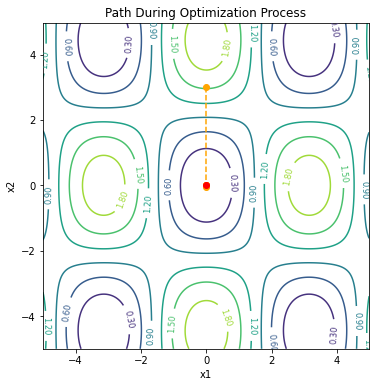

In [12]:
def create_mesh(Griewank):
    x = np.arange(-5, 5, 0.025)
    y = np.arange(-5, 5, 0.025)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros(X.shape)
    mesh_size = range(len(X))
    for i, j in product(mesh_size, mesh_size):
        x_coor = X[i][j]
        y_coor = Y[i][j]
        Z[i][j] = Griewank(np.array([x_coor, y_coor]))
    return X, Y, Z

def plot_contour(ax, X, Y, Z):
    ax.set(
        title='Path During Optimization Process',
        xlabel='x1',
        ylabel='x2'
    )
    CS = ax.contour(X, Y, Z)
    ax.clabel(CS, fontsize='smaller', fmt='%1.2f')
    ax.axis('square')
    return ax
    
fig, ax= plt.subplots(figsize=(6, 6))
X, Y, Z = create_mesh(Griewank)
ax = plot_contour(ax, X, Y, Z)
ax.plot(xs[:,0], xs[:,1], linestyle='--', marker='o', color='orange')
ax.plot(xs[-1,0], xs[-1,1], 'ro')
plt.show()

In [13]:
X, Y, Z = create_mesh(Griewank)
def plot_value(ax):
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set(
        title='Objective Function Value During Optimization Process',
        xlabel='Iterations',
        ylabel='Objective Function Value'
    )
    ax.legend(['Wolfe line search algorithm'])
    return ax


def plot(xs, ys):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    plt.suptitle('Gradient Descent Method')
    
    ax1 = plot_contour(ax1, X, Y, Z)
    ax1.plot(xs[:,0], xs[:,1], linestyle='--', marker='o', color='orange')
    ax1.plot(xs[-1,0], xs[-1,1], 'ro')
    
    ax2 = plot_value(ax2)
    ax2.plot(ys, linestyle='--', marker='o', color='orange')
    ax2.plot(len(ys)-1, ys[-1], 'ro')

    plt.tight_layout()
    plt.show()

Initial condition: y = 1.3176, x = [2 1] 

Iteration: 1 	 y = 0.5170, x = [0.24349683 1.48375642], gradient = 0.6077
Iteration: 2 	 y = 0.3194, x = [-0.41339207  1.03582246], gradient = 0.5266
Iteration: 3 	 y = 0.0004, x = [-0.0111065   0.03545872], gradient = 0.0209
Iteration: 4 	 y = 0.0004, x = [-0.00716495  0.0369848 ], gradient = 0.0198
Iteration: 5 	 y = 0.0000, x = [0.00535324 0.00406989], gradient = 0.0057
Iteration: 6 	 y = 0.0000, x = [-5.84157611e-08  1.86121246e-07], gradient = 0.0000

Solution: 	 y = 0.0000, x = [-5.84157611e-08  1.86121246e-07]


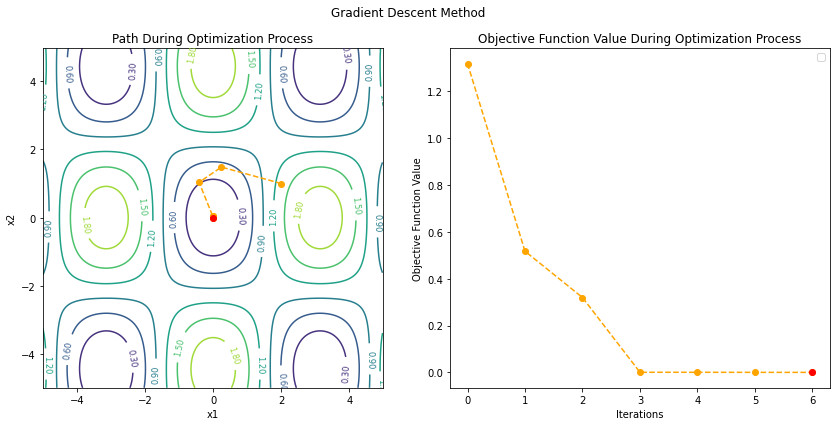

In [14]:
x0 = np.array([2, 1])
xs, ys = NonlinearCG(Griewank, GriewankGrad, init=x0, method='PR')
plot(xs, ys)